In [30]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
ts.set_token('457a66c9299e50e9e0b2bf6c2f122bb24d560735f01b443158d1c85e')
# 日线接口
pro = ts.pro_api()
# df = pro.daily(ts_code='000001.SH', start_date='20100701', end_date='20190923')
df = ts.pro_bar(ts_code='000300.SH', asset='I', start_date='20100701', end_date='20191201')


/Users/chaozhan/opt/anaconda3/envs/py375/lib/python3.7/site-packages/tushare/util/upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [31]:
df['trade_date'] = pd.to_datetime(df['trade_date'])
df.set_index('trade_date', inplace=True)

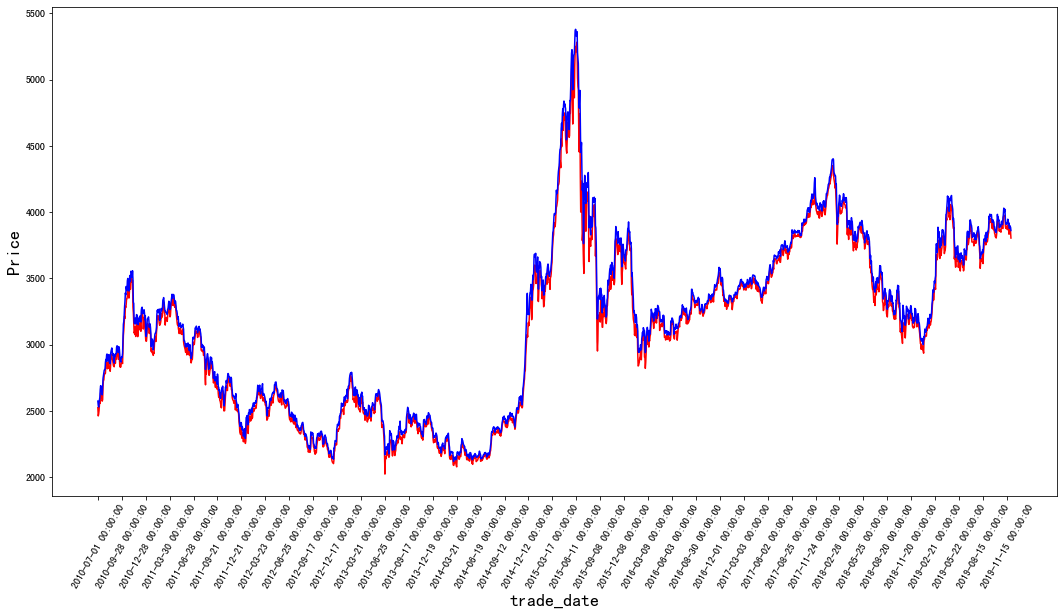

In [32]:
df=df.sort_index(ascending=True)
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']), color='r')
plt.plot(range(df.shape[0]),(df['high']), color = 'b')
plt.xticks(range(0,df.shape[0],60),df.index[::60],rotation=60)
plt.xlabel('trade_date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()

In [33]:
high_prices = df.loc[:,'high'].values
low_prices = df.loc[:,'low'].values
mid_prices = (high_prices+low_prices)/2.0
mid_prices.shape

(2291,)

In [34]:
train_test_split = int(mid_prices.shape[0]*0.8)
train_data = mid_prices[:train_test_split]
test_data = mid_prices[train_test_split:]
train_data = train_data.reshape(-1,1)         #scaler.fit_transform
test_data = test_data.reshape(-1,1)           #scaler.fit_transform

print('%d training and %d total testing instances'%(len(train_data),    
      len(test_data)))

1832 training and 459 total testing instances


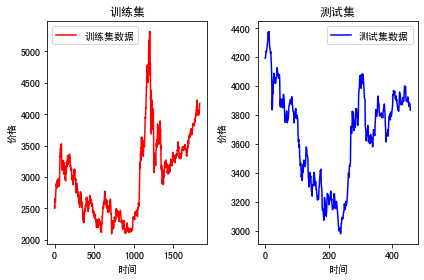

In [35]:
#Subplot with training data
plt.subplot(1,2,1)
plt.plot(range(train_data.shape[0]),train_data,color='r',label='训练集数据')
plt.title('训练集')
plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()

#Subplot with test data
plt.subplot(1,2,2)
plt.plot(range(test_data.shape[0]),test_data,color='b',label='测试集数据')
plt.title('测试集')
plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()

#adjust layout and plot all
plt.tight_layout()
plt.show()


In [36]:
#Window size to normalize data in chunks 
normalization_window = 250

#Feature range for normalization
scaler = MinMaxScaler(feature_range=(0, 1))

# Loop over the training data in windows of 250 instances at a time
for i in range(0,len(train_data),normalization_window):
    
    # Fit the scaler object on the data in the current window
    scaler.fit(train_data[i:i+normalization_window,:])
    
    # Transform the data in the current window into values between the chosen feature range (0 and 1)
    train_data[i:i+normalization_window,:] = scaler.transform(train_data[i:i+normalization_window,:])

# normalize the the test data
test_data=scaler.fit_transform(test_data)

In [37]:
Smoothing = 0.0     #Initialize smoothing value as zero
gamma = 0.1         #Define decay
for i in range(len(train_data)):  
    Smoothing = gamma*train_data[i] + (1-gamma)*Smoothing   # Update smoothing Value  
    train_data[i] = Smoothing # Replace datapoint with smoothened value

In [38]:
window_size = 26            # Define window size
N = train_data.size         # and length of observations

std_avg_predictions = []    # Empty list to catch std
mse_errors = []             # and mse

for i in range(window_size,N):
    # Append the standard mean per window
    std_avg_predictions.append(np.mean(train_data[i-window_size:i]))                                                                                                         
 
    # Compute mean squared error per batch 
    mse_errors.append((std_avg_predictions[-1]-train_data[i])**2) 

print('MSE error for standard averaging: %.5f' % (0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00656


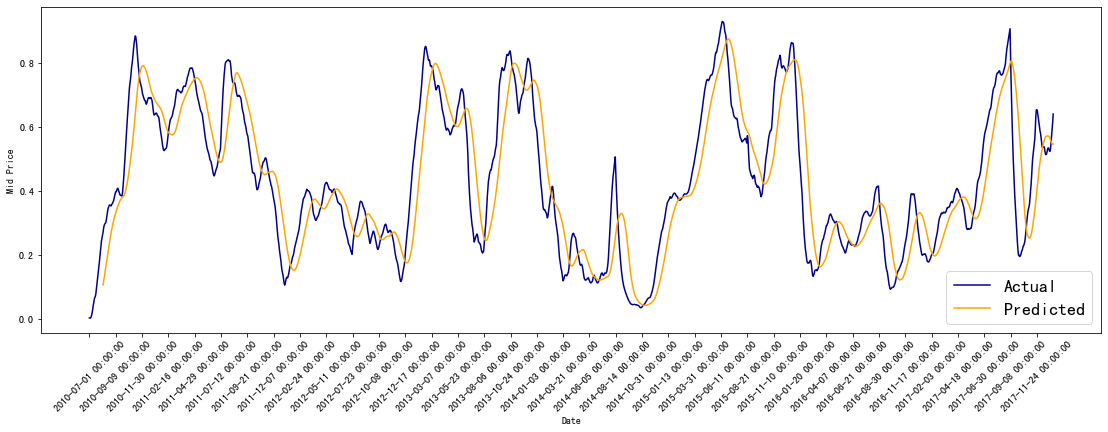

In [39]:
plt.figure(figsize = (19,6))
plt.plot(range(train_data.shape[0]),train_data,color='darkblue',label='Actual')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Predicted')
plt.xticks(range(0,df.shape[0]-len(test_data),50),df.index[::50],rotation=45)

# plt.figure(figsize = (19,6))
# plt.plot(range(test_data.shape[0]),test_data,color='darkblue',label='Actual')
# plt.plot(range(window_size,test_data.size),std_avg_predictions,color='orange',label='Predicted')
# plt.xticks(range(0,df.shape[0]-len(train_data),50),df.index[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [40]:
ema_avg_predictions = []
mse_errors = []

EMA = 0.0
ema_avg_predictions.append(EMA)

gamma = 0.9
window_size = 100
N = len(train_data)

for i in range(1,N):
    EMA = EMA*gamma + (1.0-gamma)*train_data[i-1]
    ema_avg_predictions.append(EMA)
    mse_errors.append((ema_avg_predictions[-1]-train_data[i])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00319
